In [275]:
%reset
%load_ext autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats, integrate

import glob

from fooof.fooof import *

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

import os
my_dir = '/Users/Voytek/fooof'

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


CPU times: user 153 ms, sys: 1.97 ms, total: 155 ms
Wall time: 82.2 ms
[  6.90290134   0.08316      1.42028095  10.16318659   0.9724493
   1.98803359  16.16204068   0.48795962   5.84837902  20.86370282
   0.25565732   2.66427966]


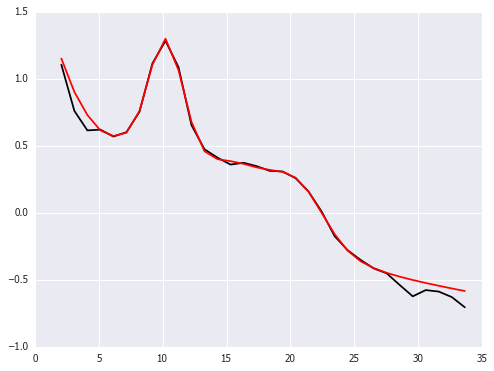

In [287]:
# eeg
file = 'data/eeg/42.npy'
filename = os.path.join(my_dir, file)
freq_range = [0, 50]
psd_array = np.load(filename)
psd_array = np.log10(psd_array)
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# Fix up PSD
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 5
cut_freqs = [2, 35]
bw_limits = [1, 6]


# Run FOOOF
%time p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

print(oscillation_params)
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()


In [277]:
files = glob.glob('labels/*.csv')
idx = [i for i, s in enumerate(files) if 'eeg' in s]

for i in range(np.size(idx)):
    if i == 0:
        df = pd.read_csv(files[idx[i]], sep=',', header='infer')
    else:
        df2 = pd.read_csv(files[idx[i]], sep=',', header='infer')
        df = df.append(df2)


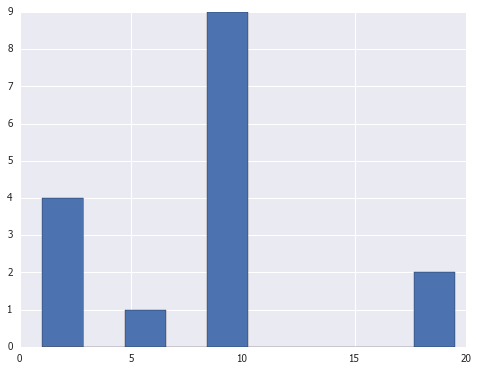

In [278]:
cf_hist = df.loc[(df['filename'] == '42.png') & (df['criterion'] == 'conservative')]

cf_hist = np.array(cf_hist['center'])

plt.hist(cf_hist)
plt.show()

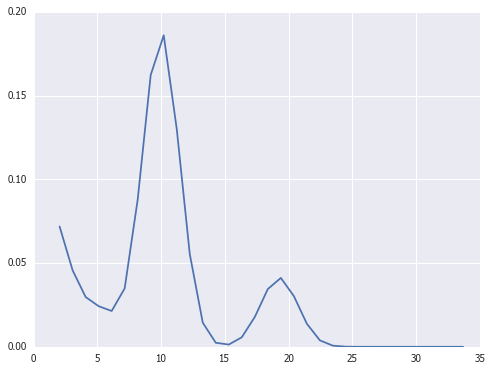

In [279]:
x = cf_hist
support = np.linspace(np.min(frequency_vector), np.max(frequency_vector), np.size(frequency_vector))
bandwidth = 1.06 * x.std() * x.size ** (-1 / 2.)
kernels = []
for i in x:
    kernel = stats.norm(i, bandwidth).pdf(support)
    kernels.append(kernel)

density = np.sum(kernels, axis=0)
density /= integrate.trapz(density, support)
plt.plot(support, density)
plt.show()

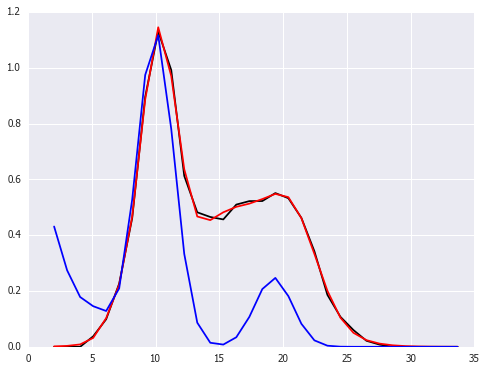

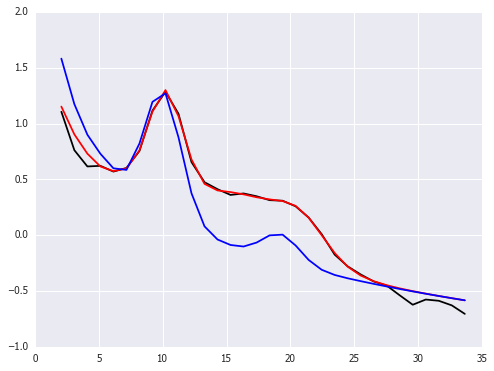

In [285]:
plt.plot(frequency_vector, p_flat_real, 'k')
plt.plot(frequency_vector, gaussian_fit, 'r')
plt.plot(frequency_vector, density*6, 'b')
plt.show()

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.plot(frequency_vector, (density*6)+background_fit, 'b')
plt.show()

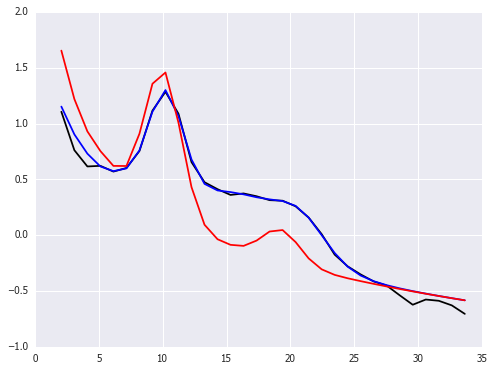

In [239]:
plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, background_fit+(gaussian_fit), 'b')
plt.plot(frequency_vector, background_fit+(density*7), 'r')
plt.show()

In [332]:
# human lablers
files = glob.glob('labels/*.csv')
idx = [i for i, s in enumerate(files) if 'eeg' in s]
for i in range(np.size(idx)):
    if i == 0:
        df = pd.read_csv(files[idx[i]], sep=',', header='infer')
    else:
        df2 = pd.read_csv(files[idx[i]], sep=',', header='infer')
        df = df.append(df2)

# foof stuff
freq_range = [0, 50]
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 5
cut_freqs = [2, 35]
bw_limits = [0.5, 6]
        
psd_files = df['filename'].unique()
num_of_psds = np.size(psd_files)
r_hum_flat = np.zeros_like(psd_files)
r_hum_fit = np.zeros_like(psd_files)
r_fit_flat = np.zeros_like(psd_files)
for fi in range(num_of_psds):
    dot_idx = [i for i, s in enumerate(psd_files[fi]) if '.' in s]
    psd_name = psd_files[fi][0:dot_idx[0]]

    # eeg
    file = 'data/eeg/' + psd_name + '.npy'
    filename = os.path.join(my_dir, file)
    psd_array = np.load(filename)
    psd_array = np.log10(psd_array)
    psd_array = np.vstack((psd_array, psd_array))
    psd_array = psd_array.T
    # Run FOOOF
    p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
        fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

    support = np.linspace(np.min(frequency_vector), np.max(frequency_vector), np.size(frequency_vector))
    
    cf_hist = df.loc[(df['filename'] == psd_name + '.png') & (df['criterion'] == 'conservative')]
    cf_hist = np.array(cf_hist['center'])
    bandwidth = 1.06 * cf_hist.std() * cf_hist.size ** (-1 / 2.)
    kernels1 = []
    for i in cf_hist:
        kernel = stats.norm(i, bandwidth).pdf(support)
        kernels1.append(kernel)
        
    cf_hist = df.loc[(df['filename'] == psd_name + '.png') & (df['criterion'] == 'liberal')]
    cf_hist = np.array(cf_hist['center'])
    bandwidth = 1.06 * cf_hist.std() * cf_hist.size ** (-1 / 2.)
    kernels2 = []
    for i in cf_hist:
        kernel = stats.norm(i, bandwidth).pdf(support)
        kernels2.append(kernel)
        
    density = np.sum(kernels1, axis=0) + (0.25*np.sum(kernels2, axis=0))
    density /= integrate.trapz(density, support)

    r_hum_flat[fi],_ = stats.spearmanr(density, p_flat_real)
    r_hum_fit[fi],_ = stats.spearmanr(density, gaussian_fit)
    r_fit_flat[fi],_ = stats.spearmanr(p_flat_real, gaussian_fit)
    
r_hum_flat = r_hum_flat.astype('float64')
r_hum_fit = r_hum_fit.astype('float64')
r_fit_flat = r_fit_flat.astype('float64')

print(np.mean(r_hum_flat**2), np.mean(r_hum_fit**2), np.mean(r_fit_flat**2))

0.269376797456 0.252770172326 0.790621617687


In [333]:
# human lablers
files = glob.glob('labels/*.csv')
idx = [i for i, s in enumerate(files) if 'lfp' in s]
for i in range(np.size(idx)):
    if i == 0:
        df = pd.read_csv(files[idx[i]], sep=',', header='infer')
    else:
        df2 = pd.read_csv(files[idx[i]], sep=',', header='infer')
        df = df.append(df2)

# foof stuff
freq_range = [0, 50]
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 5
cut_freqs = [2, 45]
bw_limits = [0.5, 6]
        
psd_files = df['filename'].unique()
num_of_psds = np.size(psd_files)
r_hum_flat = np.zeros_like(psd_files)
r_hum_fit = np.zeros_like(psd_files)
r_fit_flat = np.zeros_like(psd_files)
for fi in range(num_of_psds):
    dot_idx = [i for i, s in enumerate(psd_files[fi]) if '.' in s]
    psd_name = psd_files[fi][0:dot_idx[0]]

    # eeg
    file = 'data/lfp/' + psd_name + '.npy'
    filename = os.path.join(my_dir, file)
    psd_array = np.load(filename)
    psd_array = np.log10(psd_array)
    psd_array = np.vstack((psd_array, psd_array))
    psd_array = psd_array.T
    # Run FOOOF
    p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
        fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

    support = np.linspace(np.min(frequency_vector), np.max(frequency_vector), np.size(frequency_vector))
    
    try:
        cf_hist = df.loc[(df['filename'] == psd_name + '.png') & (df['criterion'] == 'conservative')]
        cf_hist = np.array(cf_hist['center'])
        bandwidth = 1.06 * cf_hist.std() * cf_hist.size ** (-1 / 2.)
        kernels1 = []
        for i in cf_hist:
            kernel = stats.norm(i, bandwidth).pdf(support)
            kernels1.append(kernel)

        cf_hist = df.loc[(df['filename'] == psd_name + '.png') & (df['criterion'] == 'liberal')]
        cf_hist = np.array(cf_hist['center'])
        bandwidth = 1.06 * cf_hist.std() * cf_hist.size ** (-1 / 2.)
        kernels2 = []
        for i in cf_hist:
            kernel = stats.norm(i, bandwidth).pdf(support)
            kernels2.append(kernel)

        density = np.sum(kernels1, axis=0) + (0.25*np.sum(kernels2, axis=0))
        density /= integrate.trapz(density, support)
    except:
        density = np.zeros_like(support)

    r_hum_flat[fi],_ = stats.spearmanr(density, p_flat_real)
    r_hum_fit[fi],_ = stats.spearmanr(density, gaussian_fit)
    r_fit_flat[fi],_ = stats.spearmanr(p_flat_real, gaussian_fit)
    
r_hum_flat = r_hum_flat.astype('float64')
r_hum_fit = r_hum_fit.astype('float64')
r_fit_flat = r_fit_flat.astype('float64')

print(np.nanmean(r_hum_flat**2), np.nanmean(r_hum_fit**2), np.nanmean(r_fit_flat**2))

/Users/Voytek/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1649: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


ValueError: The input must have at least 3 entries!

#### 

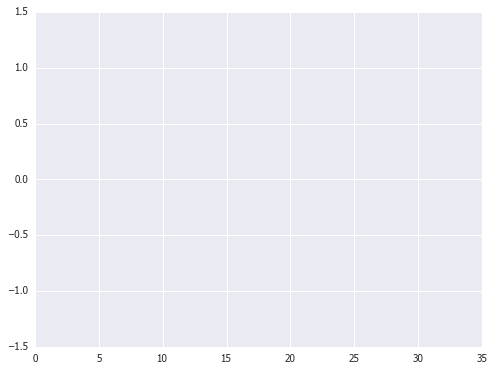

In [320]:
# human lablers
files = glob.glob('labels/*.csv')
idx = [i for i, s in enumerate(files) if 'eeg' in s]
for i in range(np.size(idx)):
    if i == 0:
        df = pd.read_csv(files[idx[i]], sep=',', header='infer')
    else:
        df2 = pd.read_csv(files[idx[i]], sep=',', header='infer')
        df = df.append(df2)

# foof stuff
freq_range = [0, 50]
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 5
cut_freqs = [2, 35]
bw_limits = [0.5, 6]
        
psd_files = df['filename'].unique()
num_of_psds = np.size(psd_files)
r_hum_flat = np.zeros_like(psd_files)
r_hum_fit = np.zeros_like(psd_files)
r_fit_flat = np.zeros_like(psd_files)
for fi in range(num_of_psds):
    dot_idx = [i for i, s in enumerate(psd_files[fi]) if '.' in s]
    psd_name = psd_files[fi][0:dot_idx[0]]

    # eeg
    file = 'data/eeg/' + psd_name + '.npy'
    filename = os.path.join(my_dir, file)
    psd_array = np.load(filename)
    psd_array = np.log10(psd_array)
    psd_array = np.vstack((psd_array, psd_array))
    psd_array = psd_array.T
    # Run FOOOF
    p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
        fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

    support = np.linspace(np.min(frequency_vector), np.max(frequency_vector), np.size(frequency_vector))
    
    cf_hist = df.loc[(df['filename'] == psd_name + '.png') & (df['criterion'] == 'conservative')]
    cf_hist = np.array(cf_hist['center'])
    bandwidth = 1.06 * cf_hist.std() * cf_hist.size ** (-1 / 2.)
    kernels1 = []
    for i in cf_hist:
        kernel = stats.norm(i, bandwidth).pdf(support)
        kernels1.append(kernel)
        
    cf_hist = df.loc[(df['filename'] == psd_name + '.png') & (df['criterion'] == 'liberal')]
    cf_hist = np.array(cf_hist['center'])
    bandwidth = 1.06 * cf_hist.std() * cf_hist.size ** (-1 / 2.)
    kernels2 = []
    for i in cf_hist:
        kernel = stats.norm(i, bandwidth).pdf(support)
        kernels2.append(kernel)
        
    density = np.sum(kernels1, axis=0) + (0.25*np.sum(kernels2, axis=0))
    density /= integrate.trapz(density, support)

    r_hum_flat[fi],_ = stats.pearsonr(density, p_flat_real)
    r_hum_fit[fi],_ = stats.pearsonr(density, gaussian_fit)
    r_fit_flat[fi],_ = stats.pearsonr(p_flat_real, gaussian_fit)
    
    r_hum_flat[fi] = r_hum_flat[fi].astype('float64')
    r_hum_fit[fi] = r_hum_fit[fi].astype('float64')
    r_fit_flat[fi] = r_fit_flat[fi].astype('float64')
    
#     plt.plot(frequency_vector, p_flat_real, 'k', label="flat PSD")
#     plt.plot(frequency_vector, gaussian_fit, 'r', label="gaus fit")
#     plt.plot(frequency_vector, density*6, 'b', label="human KDE")
#     plt.xlabel('frequency')
#     plt.title('flattened PSD\nhum:flat = ' + str(r_hum_flat[fi]) + '\nhum:fit = ' + str(r_hum_fit[fi]) + '\nflat:fit = ' + str(r_fit_flat[fi]))
#     plt.legend()
#     plt.show()
    

    plt.plot(frequency_vector, trimmed_psd, 'k', label="flat PSD")
    plt.plot(frequency_vector, psd_fit, 'r', label="gaus fit")
    plt.plot(frequency_vector, (density*6)+background_fit, 'b', label="human KDE")
    plt.xlabel('frequency')
    plt.title('flattened PSD + 1/f\nhum:flat = ' + str(r_hum_flat[fi]) + '\nhum:fit = ' + str(r_hum_fit[fi]) + '\nflat:fit = ' + str(r_fit_flat[fi]))
    plt.legend()
    plt.savefig(psd_name + '.jpg');
    plt.cla()
#     plt.show()
    



CPU times: user 87.9 ms, sys: 1.19 ms, total: 89.1 ms
Wall time: 49.2 ms


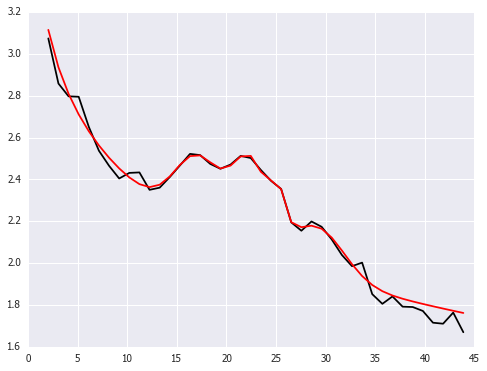

[  3.42919465e+00  -1.01535707e+00   6.23478035e-14]
[ 17.22404653   0.33450876   3.38660254  22.43791778   0.41266921
   2.62644801  25.22767735   0.16439839   0.99451009  29.16508935
   0.23149318   3.87274313]


In [330]:
# lfp
file = 'data/lfp/i010_ch08_raw.npy'
filename = os.path.join(my_dir, file)
freq_range = [0, 50]
psd_array = np.load(filename)
psd_array = np.log10(psd_array)
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# Fix up PSD
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 5
cut_freqs = [2, 45]
bw_limits = [0.5, 6]




# Run FOOOF
%time p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()
print(background_params)
print(oscillation_params)

CPU times: user 129 ms, sys: 3.45 ms, total: 133 ms
Wall time: 72.6 ms


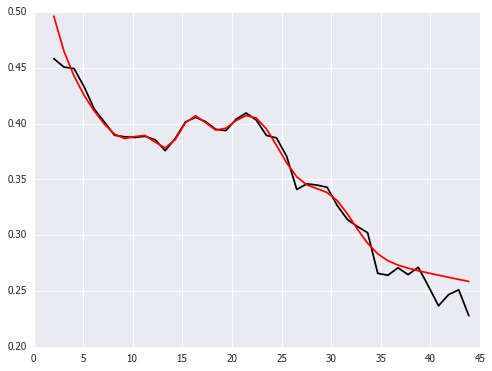

[  5.51528689e-01  -1.78398414e-01   3.56663137e-17]
[  1.14614903e+01   2.43500988e-02   2.01576110e+00   1.59397369e+01
   5.10525754e-02   2.27666894e+00   2.20943503e+01   9.47056195e-02
   4.79304751e+00   3.00344834e+01   4.16726732e-02   3.41635674e+00]


In [331]:
# lfp
file = 'data/LFP_foof/psd_i010_ch08.npy'
filename = os.path.join(my_dir, file)
freq_range = [0, 50]
psd_array = np.load(filename)
psd_array = np.log10(psd_array)
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# Fix up PSD
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T
# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 5
cut_freqs = [2, 45]
bw_limits = [0.5, 6]




# Run FOOOF
%time p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()
print(background_params)
print(oscillation_params)